In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.autonotebook import tqdm
from src.tennis import TenisSimulation

<img src="imgs/chain.jpeg" width=500>
<p>
Imagem retirada da internet, <a href="https://twitter.com/Vestige_du_jour/status/1052322461688061952">referência</a>.
</p>

In [2]:
#
n_sample = 10000
probability = 0.75

tennis_df = TenisSimulation.generate_dataset(probability, n_sample)
tennis_df.to_parquet(f'datasets/{n_sample}_probability_{probability}.parquet.gzip')

100%|██████████| 10000/10000 [00:02<00:00, 4840.13it/s]


In [3]:
tennis_df

,A scored,B scored,sets A-Wins,sets B-Wins,games A-Wins,games B-Wins,deuce,Winner
0,53,19,2,0,12,2,2,A
1,48,12,2,0,12,0,0,A
2,53,25,2,0,12,2,3,A
3,52,12,2,0,12,1,2,A
4,53,22,2,0,12,2,2,A
...,...,...,...,...,...,...,...,...
9995,57,22,2,0,12,1,7,A
9996,55,18,2,0,12,2,4,A
9997,58,25,2,0,12,1,8,A
9998,51,18,2,0,12,1,2,A


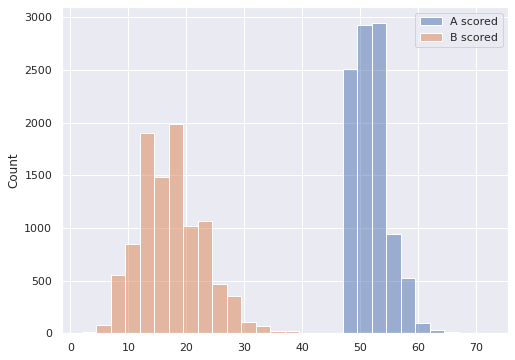

In [4]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(data=tennis_df.loc[:, ['A scored', 'B scored']], ax=ax);

In [5]:
tennis_va3_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

for i in range(0, n_sample//3):
    tennis_va3_dict['A']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'A'))
    tennis_va3_dict['B']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'B'))

    tennis_va3_dict['A']['scored'].append(sum(tennis_df.loc[i*3:i*3+3, 'A scored']))
    tennis_va3_dict['B']['scored'].append(sum(tennis_df.loc[i*3:i*3+3, 'B scored']))

    tennis_va3_dict['A']['games'].append(sum(tennis_df.loc[i*3:i*3+3, 'games A-Wins']))
    tennis_va3_dict['B']['games'].append(sum(tennis_df.loc[i*3:i*3+3, 'games B-Wins']))

    tennis_va3_dict['A']['sets'].append(sum(tennis_df.loc[i*3:i*3+3, 'sets A-Wins']))
    tennis_va3_dict['B']['sets'].append(sum(tennis_df.loc[i*3:i*3+3, 'sets B-Wins']))

In [6]:
tennis_va3_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va3_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va3_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['B']['sets'])
    }}

In [7]:
# Média
tennis_va3_mean = {
    'A': [np.mean(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_mean = pd.DataFrame(tennis_va3_mean).transpose()
tennis_va3_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va3_mean)

# Desvio padrão
tennis_va3_std = {
    'A': [np.std(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_std = pd.DataFrame(tennis_va3_std).transpose()
tennis_va3_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va3_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,3.0,206.798680,48.000600,8.0
B,0.0,68.841884,2.553855,0.0


,matches_std,scored_std,games_std,sets_std
A,0.0,5.82678,0.024489,0.0
B,0.0,11.12315,1.643759,0.0


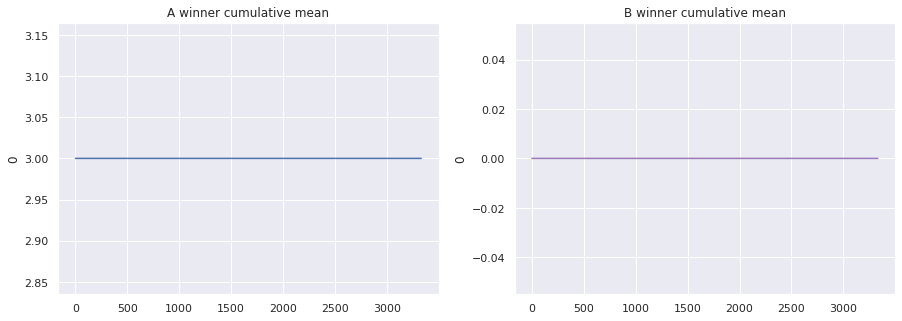

In [8]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

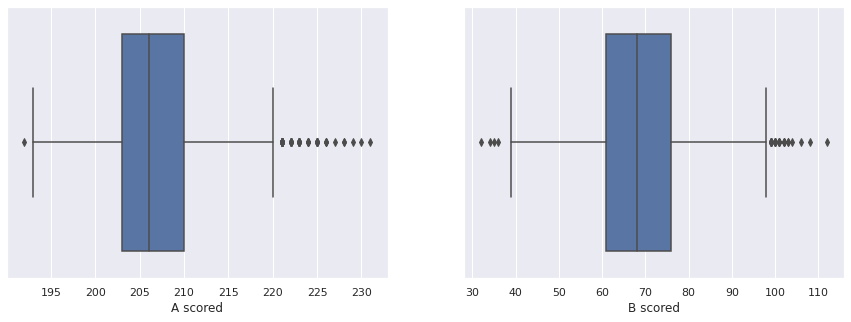

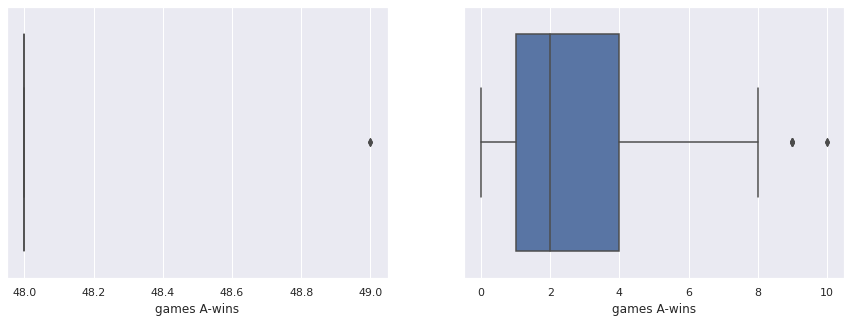

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va3_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va3_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

In [10]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va3_df_dict['A']['scored'][0], tennis_va3_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va3_df_dict['B']['scored'][0], tennis_va3_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va3_df_dict['A']['games'][0], tennis_va3_df_dict['B']['games'][0]),
    'B': percentage(tennis_va3_df_dict['B']['games'][0], tennis_va3_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va3_df_dict['A']['sets'][0], tennis_va3_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va3_df_dict['B']['sets'][0], tennis_va3_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va3_df_dict['A']['matches'][0], tennis_va3_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va3_df_dict['B']['matches'][0], tennis_va3_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.750248,0.949483,1.0,1.0
B,0.249752,0.050517,0.0,0.0


### VA com espaço amostral de 10 partidas

In [11]:
tennis_va10_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

samples = np.random.randint(0, n_sample//10, (n_sample//10, 10))

for i in range(0, n_sample//10):
    tennis_va10_dict['A']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'A'))
    tennis_va10_dict['B']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'B'))

    tennis_va10_dict['A']['scored'].append(sum(tennis_df.loc[samples[i], 'A scored']))
    tennis_va10_dict['B']['scored'].append(sum(tennis_df.loc[samples[i], 'B scored']))

    tennis_va10_dict['A']['games'].append(sum(tennis_df.loc[samples[i], 'games A-Wins']))
    tennis_va10_dict['B']['games'].append(sum(tennis_df.loc[samples[i], 'games B-Wins']))

    tennis_va10_dict['A']['sets'].append(sum(tennis_df.loc[samples[i], 'sets A-Wins']))
    tennis_va10_dict['B']['sets'].append(sum(tennis_df.loc[samples[i], 'sets B-Wins']))

In [12]:
tennis_va10_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va10_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va10_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['B']['sets'])
    }}

In [13]:
# Média
tennis_va10_mean = {
    'A': [np.mean(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_mean = pd.DataFrame(tennis_va10_mean).transpose()
tennis_va10_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va10_mean)

# Desvio padrão
tennis_va10_std = {
    'A': [np.std(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_std = pd.DataFrame(tennis_va10_std).transpose()
tennis_va10_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va10_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,10.0,517.124,120.000,20.0
B,0.0,172.489,6.867,0.0


,matches_std,scored_std,games_std,sets_std
A,0.0,9.471675,0.000000,0.0
B,0.0,17.595792,2.649021,0.0


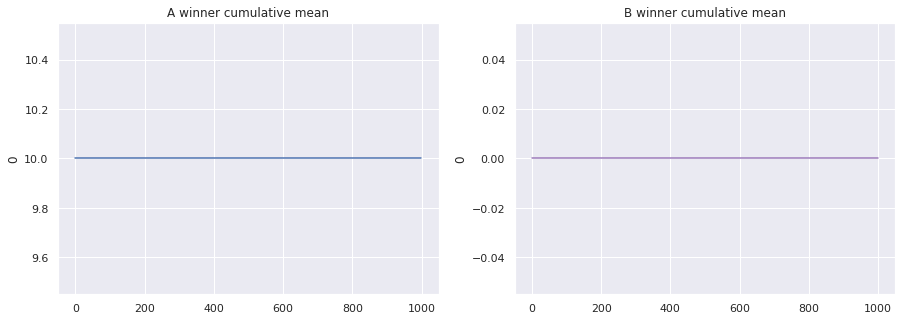

In [14]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

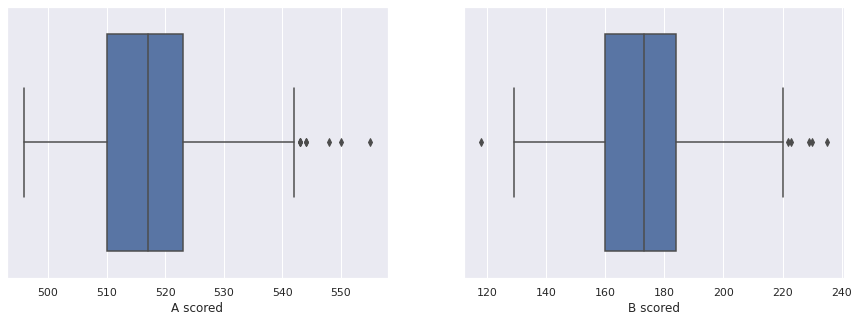

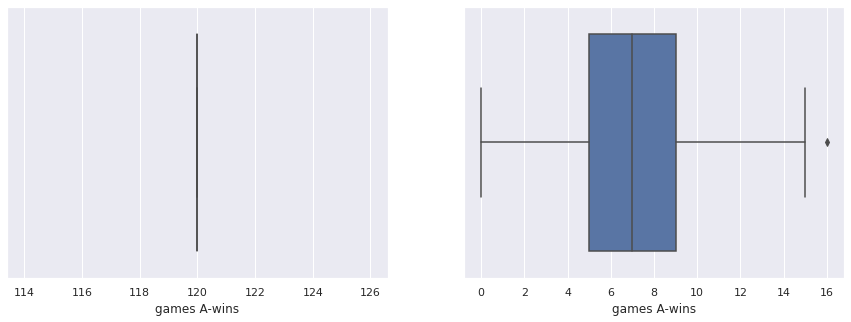

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va10_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va10_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

In [16]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va10_df_dict['A']['scored'][0], tennis_va10_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va10_df_dict['B']['scored'][0], tennis_va10_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va10_df_dict['A']['games'][0], tennis_va10_df_dict['B']['games'][0]),
    'B': percentage(tennis_va10_df_dict['B']['games'][0], tennis_va10_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va10_df_dict['A']['sets'][0], tennis_va10_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va10_df_dict['B']['sets'][0], tennis_va10_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va10_df_dict['A']['matches'][0], tennis_va10_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va10_df_dict['B']['matches'][0], tennis_va10_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.749876,0.945872,1.0,1.0
B,0.250124,0.054128,0.0,0.0


## Análise para p semelhante

In [17]:
#
n_sample = 10000
probability = 0.50

tennis_df = TenisSimulation.generate_dataset(probability, n_sample)
tennis_df.to_parquet(f'datasets/{n_sample}_probability_{probability}.parquet.gzip')

100%|██████████| 10000/10000 [00:04<00:00, 2427.41it/s]


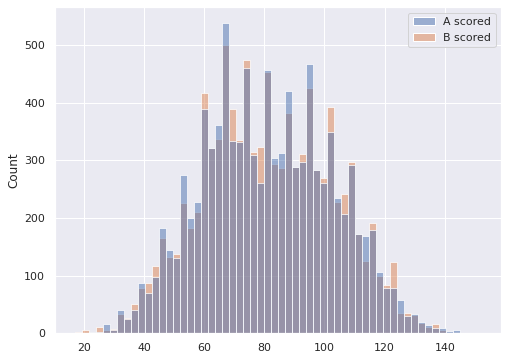

In [18]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(data=tennis_df.loc[:, ['A scored', 'B scored']], ax=ax);

In [19]:
tennis_va3_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

for i in range(0, n_sample//3):
    tennis_va3_dict['A']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'A'))
    tennis_va3_dict['B']['matches'].append(sum(tennis_df.iloc[i*3:i*3+3, :]['Winner'] == 'B'))

    tennis_va3_dict['A']['scored'].append(sum(tennis_df.loc[i*3:i*3+3, 'A scored']))
    tennis_va3_dict['B']['scored'].append(sum(tennis_df.loc[i*3:i*3+3, 'B scored']))

    tennis_va3_dict['A']['games'].append(sum(tennis_df.loc[i*3:i*3+3, 'games A-Wins']))
    tennis_va3_dict['B']['games'].append(sum(tennis_df.loc[i*3:i*3+3, 'games B-Wins']))

    tennis_va3_dict['A']['sets'].append(sum(tennis_df.loc[i*3:i*3+3, 'sets A-Wins']))
    tennis_va3_dict['B']['sets'].append(sum(tennis_df.loc[i*3:i*3+3, 'sets B-Wins']))

In [20]:
tennis_va3_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va3_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va3_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va3_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va3_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va3_dict['B']['sets'])
    }}

In [21]:
# Média
tennis_va3_mean = {
    'A': [np.mean(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_mean = pd.DataFrame(tennis_va3_mean).transpose()
tennis_va3_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va3_mean)

# Desvio padrão
tennis_va3_std = {
    'A': [np.std(i) for i in tennis_va3_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va3_dict['B'].values()]
}

tennis_va3_std = pd.DataFrame(tennis_va3_std).transpose()
tennis_va3_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va3_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,1.474347,324.186019,47.942094,4.927693
B,1.525653,324.823882,48.270327,5.031503


,matches_std,scored_std,games_std,sets_std
A,0.860344,44.208344,7.763181,1.669476
B,0.860344,43.507015,7.567229,1.659212


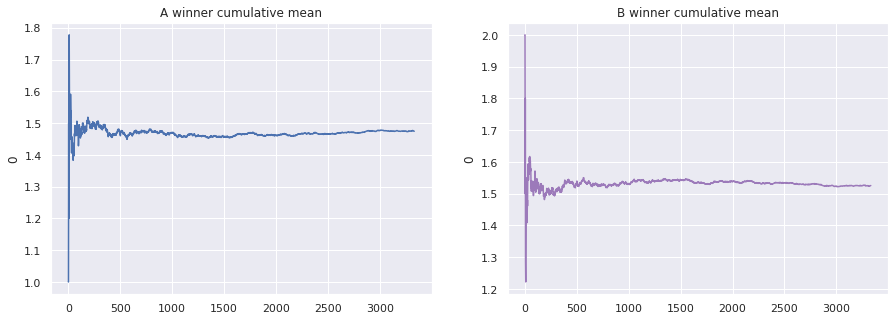

In [22]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va3_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

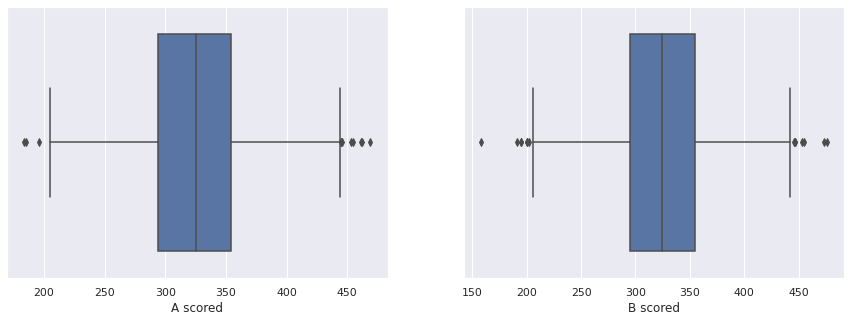

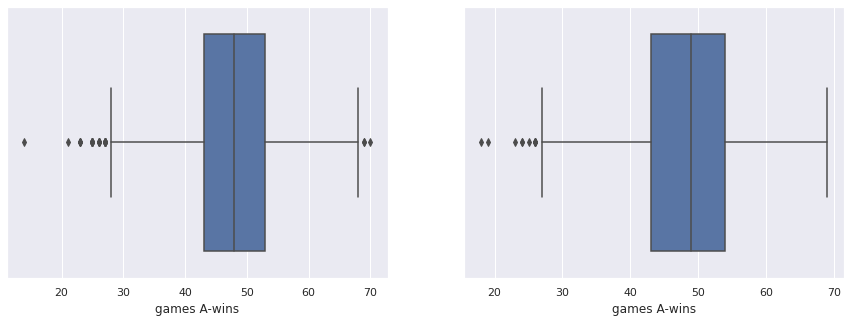

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va3_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va3_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va3_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

In [24]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va3_df_dict['A']['scored'][0], tennis_va3_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va3_df_dict['B']['scored'][0], tennis_va3_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va3_df_dict['A']['games'][0], tennis_va3_df_dict['B']['games'][0]),
    'B': percentage(tennis_va3_df_dict['B']['games'][0], tennis_va3_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va3_df_dict['A']['sets'][0], tennis_va3_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va3_df_dict['B']['sets'][0], tennis_va3_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va3_df_dict['A']['matches'][0], tennis_va3_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va3_df_dict['B']['matches'][0], tennis_va3_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.499509,0.498294,0.494788,0.491449
B,0.500491,0.501706,0.505212,0.508551


### VA com espaço amostral de 10 partidas

In [25]:
tennis_va10_dict = { 
    'A': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
    'B': { 'matches' : [], 'scored' : [], 'games' : [], 'sets' : []},
}

samples = np.random.randint(0, n_sample//10, (n_sample//10, 10))

for i in range(0, n_sample//10):
    tennis_va10_dict['A']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'A'))
    tennis_va10_dict['B']['matches'].append(sum(tennis_df.iloc[samples[i], :]['Winner'] == 'B'))

    tennis_va10_dict['A']['scored'].append(sum(tennis_df.loc[samples[i], 'A scored']))
    tennis_va10_dict['B']['scored'].append(sum(tennis_df.loc[samples[i], 'B scored']))

    tennis_va10_dict['A']['games'].append(sum(tennis_df.loc[samples[i], 'games A-Wins']))
    tennis_va10_dict['B']['games'].append(sum(tennis_df.loc[samples[i], 'games B-Wins']))

    tennis_va10_dict['A']['sets'].append(sum(tennis_df.loc[samples[i], 'sets A-Wins']))
    tennis_va10_dict['B']['sets'].append(sum(tennis_df.loc[samples[i], 'sets B-Wins']))

In [26]:
tennis_va10_df_dict = {
    'A': {
        'matches': pd.DataFrame(tennis_va10_dict['A']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['A']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['A']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['A']['sets'])
    },
    'B': {
        'matches': pd.DataFrame(tennis_va10_dict['B']['matches']),
        'scored': pd.DataFrame(tennis_va10_dict['B']['scored']),
        'games': pd.DataFrame(tennis_va10_dict['B']['games']),
        'sets': pd.DataFrame(tennis_va10_dict['B']['sets'])
    }}

In [27]:
# Média
tennis_va10_mean = {
    'A': [np.mean(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.mean(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_mean = pd.DataFrame(tennis_va10_mean).transpose()
tennis_va10_mean.columns = ['matches_mean', 'scored_mean', 'games_mean', 'sets_mean']
display(tennis_va10_mean)

# Desvio padrão
tennis_va10_std = {
    'A': [np.std(i) for i in tennis_va10_dict['A'].values()],
    'B': [np.std(i) for i in tennis_va10_dict['B'].values()]
}

tennis_va10_std = pd.DataFrame(tennis_va10_std).transpose()
tennis_va10_std.columns = ['matches_std', 'scored_std', 'games_std', 'sets_std']
display(tennis_va10_std)

,matches_mean,scored_mean,games_mean,sets_mean
A,4.917,814.318,119.806,12.249
B,5.083,816.075,121.731,12.771


,matches_std,scored_std,games_std,sets_std
A,1.631598,69.373762,12.171703,2.712748
B,1.631598,68.373689,11.937614,2.680030


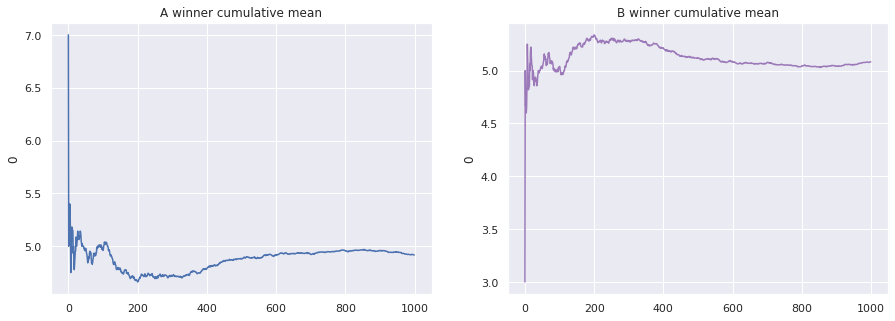

In [28]:
# Gráfico da média acumulada
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('A winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['A']['matches'].expanding().mean().iloc[:, 0], ax=ax[0]);

ax[1].set_title('B winner cumulative mean')
sns.lineplot(data=tennis_va10_df_dict['B']['matches'].expanding().mean().iloc[:, 0], ax=ax[1], color='#9C7ABA');

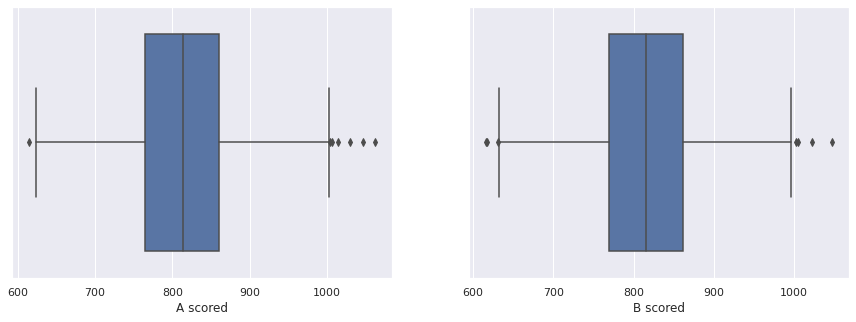

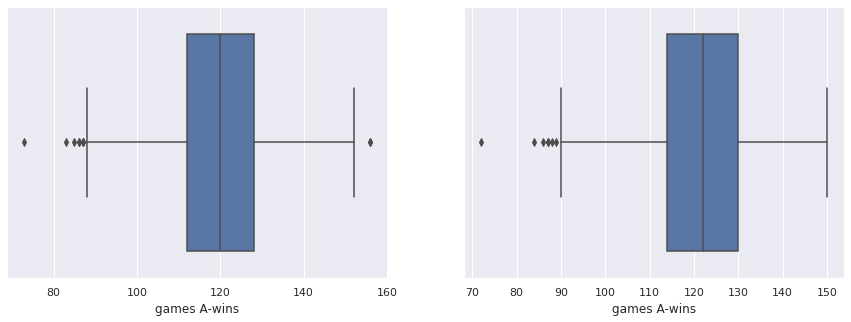

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['scored'][0], ax=ax[0]);
ax[0].set_xlabel('A scored')
sns.boxplot(x=tennis_va10_df_dict['B']['scored'][0], ax=ax[1]);
ax[1].set_xlabel('B scored')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=tennis_va10_df_dict['A']['games'][0], ax=ax[0]);
ax[0].set_xlabel('games A-wins')
sns.boxplot(x=tennis_va10_df_dict['B']['games'][0], ax=ax[1]);
ax[1].set_xlabel('games A-wins');

In [30]:
def percentage(data_a: pd.DataFrame, data_b: pd.DataFrame):
    data_a = data_a.sum()
    data_b = data_b.sum()
    return (data_a) / (data_a + data_b)

percentages = {}

percentages['scored'] = {
    'A': percentage(tennis_va10_df_dict['A']['scored'][0], tennis_va10_df_dict['B']['scored'][0]),
    'B': percentage(tennis_va10_df_dict['B']['scored'][0], tennis_va10_df_dict['A']['scored'][0])
}
percentages['games'] = {
    'A': percentage(tennis_va10_df_dict['A']['games'][0], tennis_va10_df_dict['B']['games'][0]),
    'B': percentage(tennis_va10_df_dict['B']['games'][0], tennis_va10_df_dict['A']['games'][0])
}
percentages['sets'] = {
    'A': percentage(tennis_va10_df_dict['A']['sets'][0], tennis_va10_df_dict['B']['sets'][0]),
    'B': percentage(tennis_va10_df_dict['B']['sets'][0], tennis_va10_df_dict['A']['sets'][0])
}
percentages['matches'] = {
    'A': percentage(tennis_va10_df_dict['A']['matches'][0], tennis_va10_df_dict['B']['matches'][0]),
    'B': percentage(tennis_va10_df_dict['B']['matches'][0], tennis_va10_df_dict['A']['matches'][0])
}

percentages_df = pd.DataFrame(percentages)
percentages_df

,scored,games,sets,matches
A,0.499461,0.496015,0.489568,0.4917
B,0.500539,0.503985,0.510432,0.5083


## Vários P

In [41]:
%%capture
def percentage(df: pd.DataFrame, column_a: str, column_b: str):
    data_a = df.loc[:, column_a].sum()
    data_b = df.loc[:, column_b].sum()
    return (data_a) / (data_a + data_b)

p_values = pd.DataFrame([])

for i in range(0, 1001):
    n_sample = 100
    p = i * 0.0009 + 0.1
    tennis_df = TenisSimulation.generate_dataset(p, n_sample)

    percentages = {}
    percentages['p'] = p
    percentages['games'] = {'A': percentage(tennis_df, 'games A-Wins', 'games B-Wins')}
    percentages['sets'] = {'A': percentage(tennis_df, 'sets A-Wins', 'sets B-Wins')}
    percentages['matches'] = {'A': tennis_df[tennis_df['Winner'] == 'A'].shape[0] / tennis_df.shape[0]}
    percentages['scores'] = {'A': percentage(tennis_df, 'A scored', 'B scored')}

    percentages_df = pd.DataFrame(percentages)
    p_values = pd.concat([p_values, percentages_df])

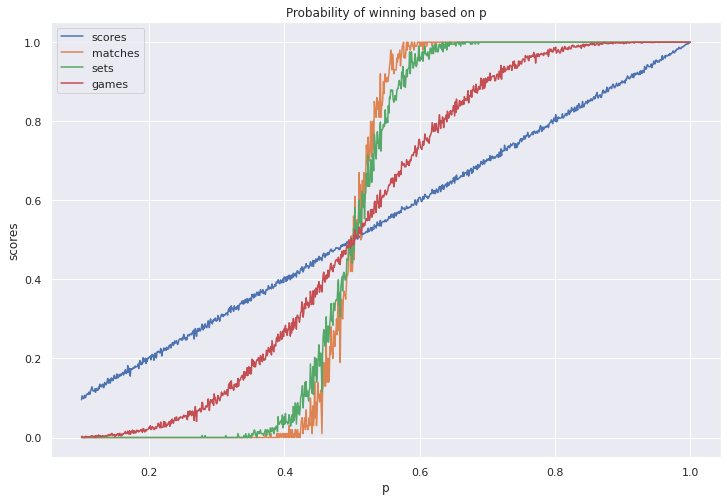

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title('Probability of winning based on p')
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='scores', ax=ax, label='scores');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='matches', ax=ax, label='matches');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='sets', ax=ax, label='sets');
sns.lineplot(data=p_values.copy().reset_index(), x='p', y='games', ax=ax, label='games');